## Курсовая работа

Выполнил Нурмухамедов Абубакир М8О-114СВ-24

## Table dataset - ✈️ Tourism and Economic Impact Dataset

Ссылка на датасет: https://www.kaggle.com/datasets/bushraqurban/tourism-and-economic-impact/code?datasetId=6352827&sortBy=voteCount

Этот набор данных включает в себя ключевые туристические и экономические показатели для более чем 200 стран, охватывающих годы с 1999 по 2023 год. Он охватывает широкий спектр данных, связанных с прибыванием туристов, расходами, поступлениями, ВВП, безработицей и инфляцией, помогая исследовать взаимосвязь между туризмом и экономическим ростом во всем мире.

Данные содержат информацию о туризме и экономических показателях по странам. Вот основные столбцы:

- country: Название страны
- country_code: Код страны
- year: Год
- tourism_receipts: Доходы от туризма
- tourism_arrivals: Количество туристов
- tourism_exports: Экспорт услуг, связанных с туризмом
- tourism_departures: Количество выезжающих туристов
- tourism_expenditures: Расходы туристов
- gdp: ВВП страны
- inflation: Уровень инфляции
- unemployment: Уровень безработицы

In [47]:
!pip install catboost lime shap seaborn kagglehub
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 1.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [48]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bushraqurban/tourism-and-economic-impact")

print("Path to dataset files:", path)

Path to dataset files: /Users/abubakir/.cache/kagglehub/datasets/bushraqurban/tourism-and-economic-impact/versions/1


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_squared_error

full_path = path + '/world_tourism_economy_data.csv'

df = pd.read_csv(full_path)

# Setting visualization styles
sns.set(style="whitegrid")

In [112]:
df.sample(10)

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
2900,South Asia (IDA & IBRD),TSA,2009,NaN,8.156998e+06,NaN,1.694352e+07,NaN,1.702715e+12,4.976824,NaN
5871,Burkina Faso,BFA,2021,NaN,NaN,NaN,NaN,NaN,1.969752e+10,3.653533,NaN
2999,European Union,EUU,2010,3.172209e+11,7.084107e+08,5.593303,3.648445e+08,6.053363,1.464344e+13,1.531123,9.865117
4706,Pakistan,PAK,2016,7.900000e+08,NaN,2.940168,NaN,5.646734,3.136300e+11,3.765119,2.286000
156,Middle income,MIC,1999,NaN,3.397097e+08,9.168023,2.743136e+08,6.094455,5.124149e+12,4.861923,NaN
169,Malaysia,MYS,1999,4.403000e+09,7.931000e+06,4.588007,2.606700e+07,3.128474,7.914842e+10,2.744561,3.430000
6648,Zambia,ZMB,2023,NaN,NaN,NaN,NaN,NaN,2.757796e+10,10.884532,NaN
3822,Heavily indebted poor countries (HIPC),HPC,2013,1.488955e+10,2.128559e+07,9.074693,NaN,4.352828,6.578597e+11,5.161899,NaN
2247,Japan,JPN,2007,1.242200e+10,8.347000e+06,1.548487,1.729500e+07,5.184085,4.579751e+12,0.060039,3.888000
3175,Upper middle income,UMC,2010,NaN,4.220265e+08,NaN,2.807392e+08,NaN,1.463224e+13,3.911062,5.380149


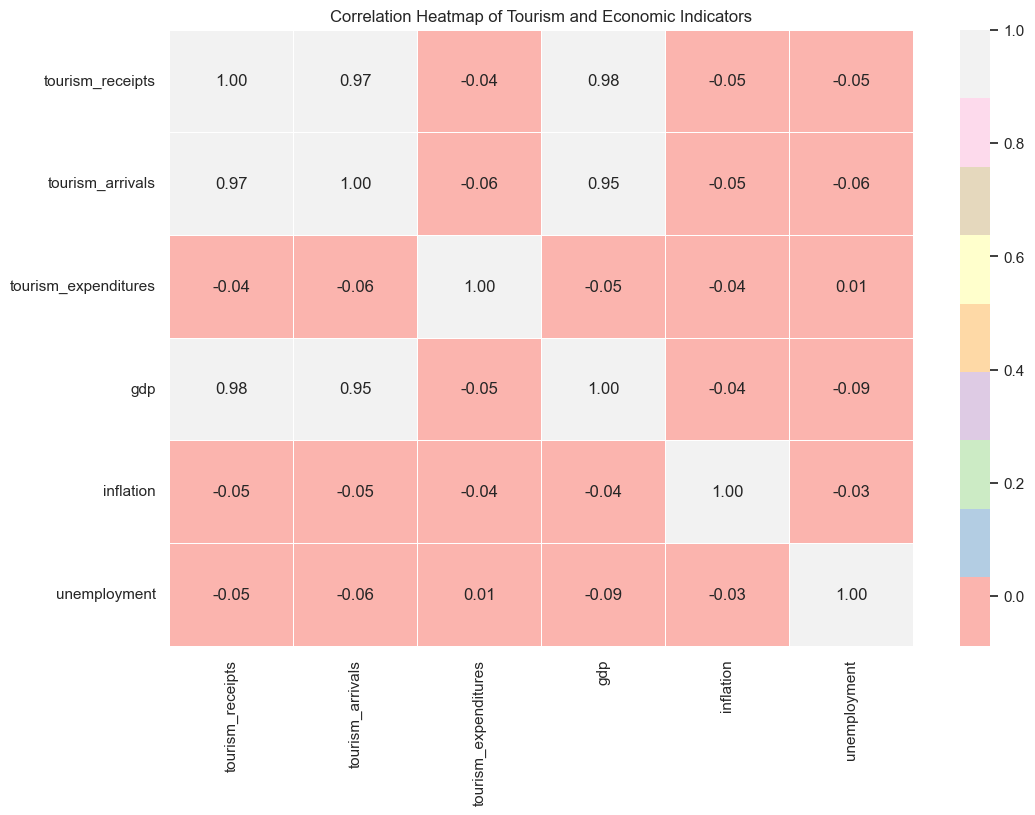

In [113]:
correlation_matrix = df[['tourism_receipts', 'tourism_arrivals', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Pastel1', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Tourism and Economic Indicators')
plt.show()

## Catboost

In [115]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Удаление строк с пустыми целевыми значениями (например, tourism_receipts)
target = "tourism_receipts"
data = df.dropna(subset=[target])

# Определение признаков и целевой переменной
X = data.drop(columns=[target, "country_code", "country"])  # Удаляем текстовые категории
y = data[target]

# Заполнение пропусков (CatBoost обрабатывает их автоматически, но можно заполнить медианой)
X = X.fillna(X.median())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение категориальных признаков
categorical_features = ["year"]

# Обучение модели
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function="RMSE",
    cat_features=categorical_features,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 115339258140.9155273	test: 133173943486.3090820	best: 133173943486.3090820 (0)	total: 2.53ms	remaining: 2.53s
100:	learn: 6613155057.0094385	test: 13247930877.8908215	best: 13247930877.8908215 (100)	total: 153ms	remaining: 1.36s
200:	learn: 3798014607.2785158	test: 12593668940.2170353	best: 12593668940.2170353 (200)	total: 316ms	remaining: 1.25s
300:	learn: 2734658905.1331620	test: 12341187173.9154091	best: 12339916209.7381115 (299)	total: 456ms	remaining: 1.06s
400:	learn: 2126853757.8079419	test: 12277756427.9803181	best: 12269377194.1801910 (393)	total: 583ms	remaining: 871ms
500:	learn: 1735526813.3937595	test: 12229374745.7497253	best: 12229236547.6511383 (473)	total: 695ms	remaining: 692ms
600:	learn: 1483261558.8581111	test: 12200504756.1177063	best: 12200504756.1177063 (600)	total: 813ms	remaining: 540ms
700:	learn: 1291770295.5164120	test: 12191803544.4838638	best: 12190763499.7215214 (653)	total: 930ms	remaining: 397ms
800:	learn: 1141404266.4745510	test: 1219134933

In [116]:
from sklearn.metrics import mean_squared_error
import numpy as np

predictions = model.predict(X_test)

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

RMSE: 12166783564.025854


In [117]:
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

             Feature Id  Importances
0    tourism_departures    39.152515
1                   gdp    29.758049
2      tourism_arrivals    18.131476
3  tourism_expenditures     5.238523
4       tourism_exports     3.798239
5             inflation     2.556081
6          unemployment     1.010824
7                  year     0.354293


In [118]:
from sklearn.ensemble import RandomForestRegressor

# Создаем модель с включенной OOB-оценкой
model = RandomForestRegressor(
    n_estimators=100,
    oob_score=True,  # Включаем расчет OOB-оценки
    random_state=42
)

model.fit(X_train, y_train)

# Получаем OOB-оценку (R^2 для регрессии)
print("OOB-оценка:", model.oob_score_)

OOB-оценка: 0.9927871900005155


## LIME

In [119]:
import lime
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt

Intercept 88756584233.66776
Prediction_local [-2.8099e+09]
Right: 2118501356.4804602


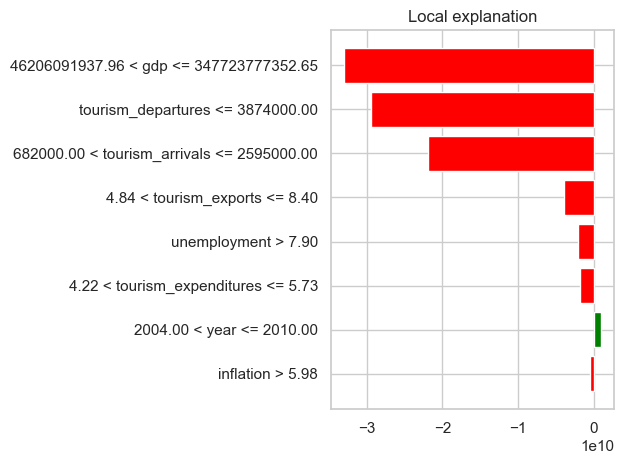

In [120]:
# Создаем объяснитель LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,  # Данные для обучения объяснителя
    feature_names=X_train.columns.tolist(),
    mode="regression",  # Для регрессии
    verbose=True
)

# Инициализируем объяснитель SHAP для CatBoost
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)

# Выбираем пример из тестовой выборки
sample_idx = 0
sample = X_test.iloc[sample_idx].values

# Генерируем объяснение
exp = explainer_lime.explain_instance(
    data_row=sample,
    predict_fn=model.predict  # Функция предсказания модели
)

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

Intercept 92551525915.08287
Prediction_local [ 7.2582e+08]
Right: 2118501356.4804602


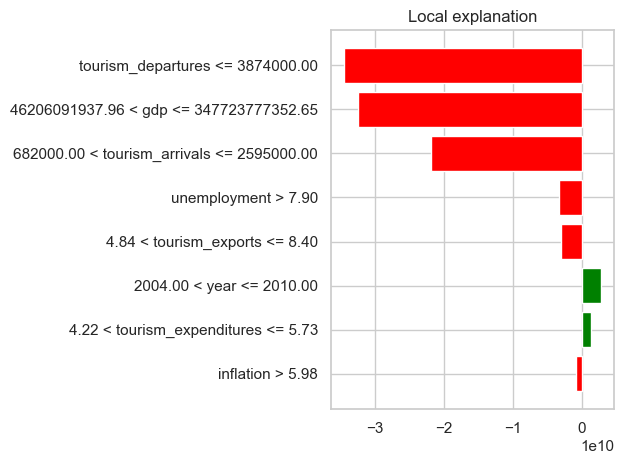

In [121]:
# Выбираем пример как DataFrame
sample = X_test.iloc[[0]]

# Обертка для predict, чтобы сохранить названия признаков
def custom_predict(data_array):
    data_df = pd.DataFrame(data_array, columns=X_train.columns)
    return model.predict(data_df)

# Генерируем объяснение
exp = explainer_lime.explain_instance(
    data_row=sample.values[0],
    predict_fn=custom_predict  # Используем обертку
)

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

## SHAP

/var/folders/5_/qd3xf9ls41q96mn9vn2661ph0000gn/T/ipykernel_67979/404442673.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


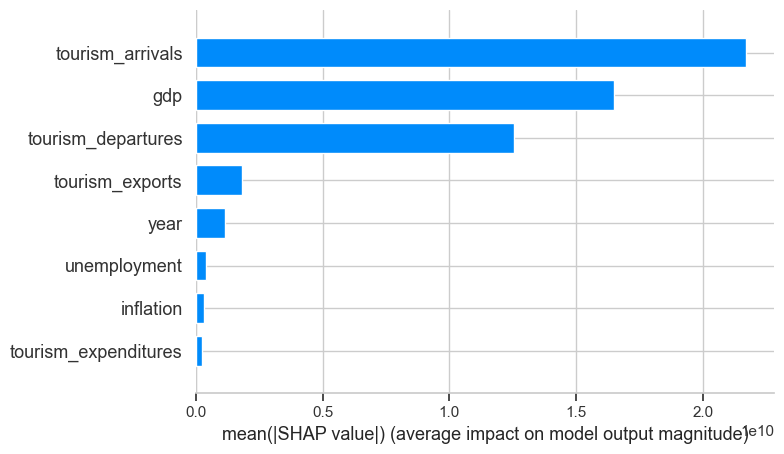

In [122]:
# Визуализация важности признаков (глобальная)
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Визуализация вклада признаков для отдельного примера
shap.force_plot(
    explainer_shap.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx]
)

Вывод:

Анализ SHAP подтвердил, что туристические поездки, ВВП и туристические выезды — ключевые факторы для прогноза дохада от туризма. LIME выявил, что расходы туристов некритично снижает эффективность туристического сектора. Инфляция и безработица несильно влияют на прогноз модели.

## Object Detection YOLOv8


image 1/1 /Users/abubakir/VisualStudioProjects/AI_LABS/car.jpg: 384x640 1 car, 39.6ms
Speed: 1.4ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


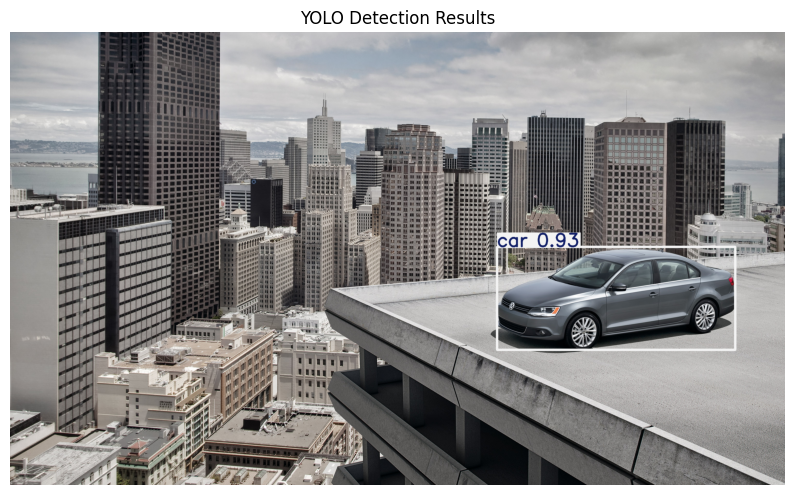

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import torch
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap
from skimage.segmentation import slic

# Загрузка модели
model = YOLO('yolov8n.pt')

# Загрузка и обработка изображения
image_path = 'car.jpg'
image = Image.open(image_path)
image_np = np.array(image)

# Детекция объектов
results = model(image_path, conf=0.5)
result = results[0]

# Визуализация результатов YOLO
detected_image = result.plot()
plt.figure(figsize=(10, 10))
plt.title('YOLO Detection Results')
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


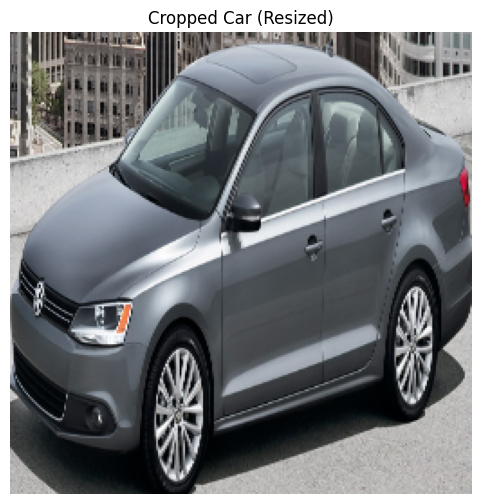

In [37]:
# Вырезаем первый найденный автомобиль (класс 2)
boxes = result.boxes.xyxy.cpu().numpy()
classes = result.boxes.cls.cpu().numpy()
car_indices = np.where(classes == 2)[0]

if len(car_indices) == 0:
    raise ValueError("No cars detected!")

x1, y1, x2, y2 = boxes[car_indices[0]].astype(int)
car_image = image_np[y1:y2, x1:x2]

# Уменьшаем размер изображения для ускорения обработки
car_image = cv2.resize(car_image, (256, 256))

# Убедимся, что изображение имеет 3 канала
if car_image.shape[-1] != 3:
    if len(car_image.shape) == 2:
        car_image = np.stack([car_image]*3, axis=-1)
    else:
        car_image = car_image[..., :3]

plt.figure(figsize=(6, 6))
plt.title('Cropped Car (Resized)')
plt.imshow(car_image)
plt.axis('off')
plt.show()

## LIME

In [38]:
# Функция предсказания для LIME/SHAP
def predict_fn(images):
    """
    Возвращает confidence автомобиля для каждого изображения
    Формат выхода: (N, 2) где:
        - столбец 0: confidence "не автомобиль"
        - столбец 1: confidence "автомобиль"
    """
    batch_output = []
    for img in images:
        # Преобразуем в PIL
        img_pil = Image.fromarray(img.astype('uint8'), 'RGB')

        # Выполняем детекцию
        result = model(img_pil, verbose=False)[0]

        # Ищем максимальный confidence для класса "автомобиль"
        confidence_car = 0.0
        if result.boxes is not None:
            cls = result.boxes.cls.cpu().numpy()
            conf = result.boxes.conf.cpu().numpy()
            car_confs = conf[cls == 2]
            if len(car_confs) > 0:
                confidence_car = np.max(car_confs)

        # Формируем выходной вектор
        batch_output.append([1 - confidence_car, confidence_car])

    return np.array(batch_output)

# LIME объяснение
explainer_lime = lime_image.LimeImageExplainer()
explanation = explainer_lime.explain_instance(
    car_image,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=300
)


100%|██████████| 300/300 [00:17<00:00, 16.92it/s]


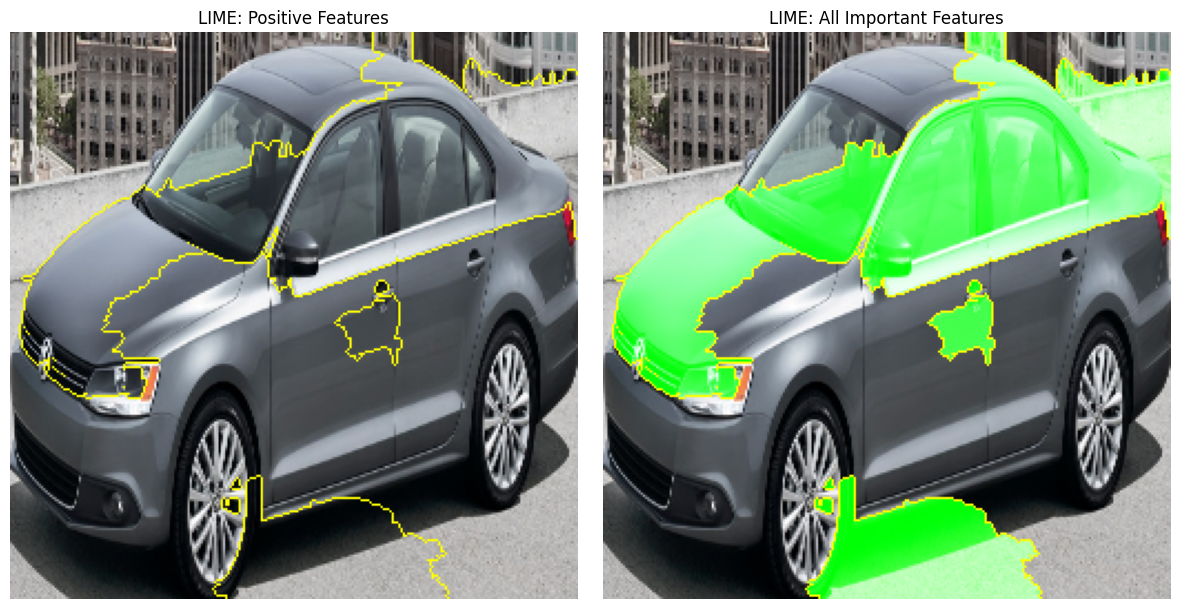

In [39]:
# Визуализация LIME
plt.figure(figsize=(12, 6))

# Положительные признаки
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)
plt.subplot(121)
plt.title('LIME: Positive Features')
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')

# Все важные признаки
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)
plt.subplot(122)
plt.title('LIME: All Important Features')
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')

plt.tight_layout()
plt.show()

## SHAP

In [40]:
# SHAP объяснение
# Используем алгоритм Partition для сегментации
segments = slic(car_image, n_segments=50, compactness=10, sigma=1)
masker = shap.maskers.Image("inpaint_telea", car_image.shape)

# Создаем объяснитель SHAP
explainer_shap = shap.Explainer(
    predict_fn,
    masker,
    algorithm="partition" # "permutation" "partition"
)

# Вычисляем SHAP значения (увеличим max_evals для точности)
shap_values = explainer_shap(
    np.expand_dims(car_image, axis=0),
    max_evals=200,  # Увеличили количество оценок
    outputs=[1]       # Объясняем класс "автомобиль"
)

PartitionExplainer explainer: 2it [00:13, 13.19s/it]               


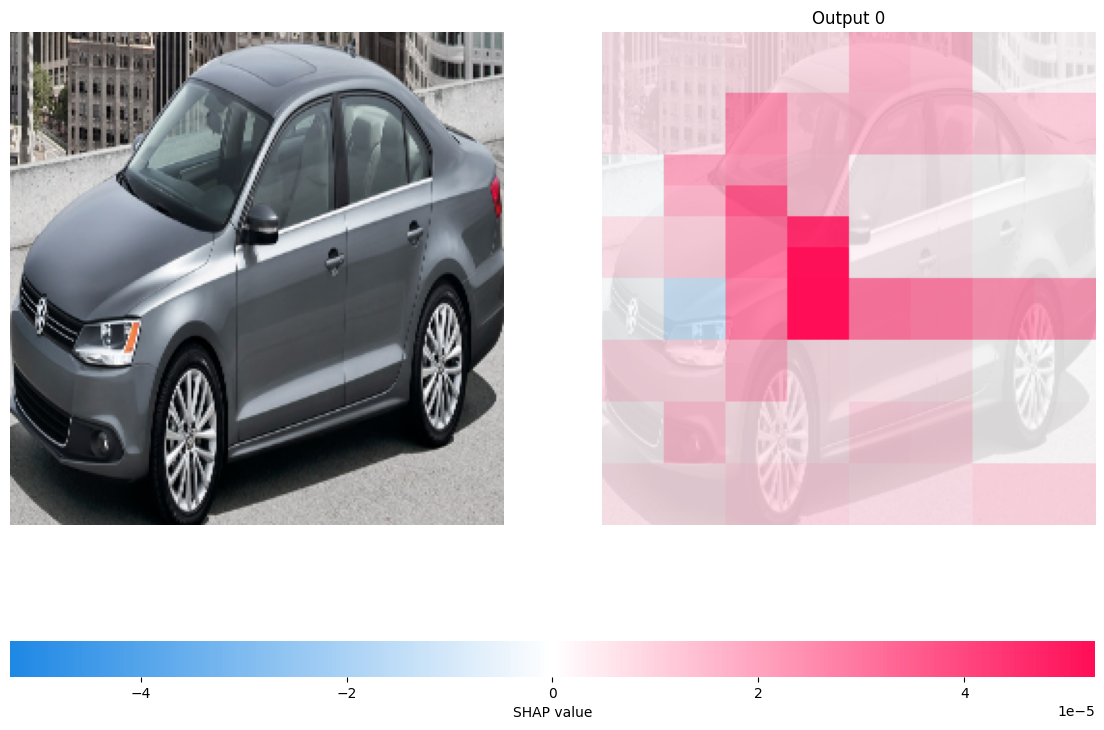

In [41]:
# Визуализация SHAP
# plt.figure(figsize=(10, 10))
# plt.title('SHAP Explanation')
shap.image_plot(
    shap_values,
    np.expand_dims(car_image, axis=0),  # Исправлен знак
    show=False
)
fig = plt.gcf()
fig.set_size_inches(14, 10)  # Ширина x Высота (в дюймах)
plt.show()

Вывод: 

Модель адекватно идентифицирует основные признаки автомобилей (боковые зеркала, фары, колеса, стекла), прогноз модели зависит от боковых зеркал, но модель игнорирует задние части транспортных средств и чувствительна к контрасту между автомобилем и фоном (то есть может терять объекты при низком контрасте или сливании с фоном)